## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Configuration

Now we define the learning method and whether there will be or not model miss-specification. 



In [2]:
## Learning Method
# 0. MAP Inference 
# 1. Variational Inference
# 2. PAC2-Varitional Inference, $\rho(\theta|D)
# 3. PAC2-Varitional Inference, $\rho_h(\theta|D)

LEARNING_METHOD = 3


# Data Set

In this first part, we present the data set used for this example.

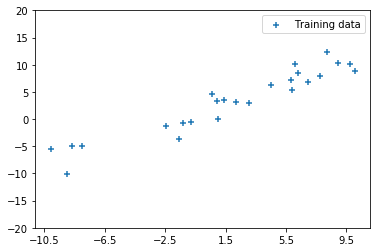

In [3]:
# Set seeds for reproducibility
np.random.seed(0)
tf.set_random_seed(0)
NSAMPLE = 25
VAR=2.

x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = 1 + np.float32(np.random.normal(size=(NSAMPLE,1),scale=VAR))
y_train = np.float32(x_train*1.0 + r_train*1.0)

plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend()
plt.show()

# Learning a Neural Network

We now employ Tensorflow Probability and Edward 2 to define and make varitional inference over a Bayesian neural network. 

In [4]:
NHIDDEN = 20

def model(NHIDDEN, NSAMPLE):
    W = ed.Normal(loc=tf.zeros([1, NHIDDEN]), scale=1., name="W")
    b = ed.Normal(loc=tf.zeros([1, NHIDDEN]), scale=1., name="b")

    W_out = ed.Normal(loc=tf.zeros([NHIDDEN, 1]), scale=1., name="W_out")
    b_out = ed.Normal(loc=tf.zeros([1, 1]), scale=1., name="b_out")

    x = ed.Normal(loc=tf.zeros([NSAMPLE, 1]), scale=1.0, name="x")
    hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
    out = tf.matmul(hidden_layer, W_out) + b_out
    y = ed.Normal(loc=out, scale=0.01, name="y")

    return W, b, W_out, b_out, x, y


def qmodel(NHIDDEN):
    W_loc = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b_loc = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))

    if LEARNING_METHOD==0:
        W_scale = -25.
        b_scale = -25.
    else:
        W_scale = tf.Variable(tf.random_normal([1, NHIDDEN], -10., stddev=0.05, dtype=tf.float32))
        b_scale = tf.Variable(tf.random_normal([1, NHIDDEN], -10., stddev=0.05, dtype=tf.float32))

    qW = ed.Normal(W_loc, scale=tf.nn.softplus(W_scale), name="W")
    qW_ = ed.Normal(W_loc, scale=tf.nn.softplus(W_scale), name="W")

    qb = ed.Normal(b_loc, scale=tf.nn.softplus(b_scale), name="b")
    qb_ = ed.Normal(b_loc, scale=tf.nn.softplus(b_scale), name="b")

    W_out_loc = tf.Variable(tf.random_normal([NHIDDEN, 1], 0.0, 0.05, dtype=tf.float32))
    b_out_loc = tf.Variable(tf.random_normal([1, 1], 0.0, 0.05, dtype=tf.float32))
    if LEARNING_METHOD==0:
        W_out_scale = -25.
        b_out_scale = -25.
    else:
        W_out_scale = tf.Variable(tf.random_normal([NHIDDEN, 1], -10., stddev=0.05, dtype=tf.float32))
        b_out_scale = tf.Variable(tf.random_normal([1, 1], -10., stddev=0.05, dtype=tf.float32))

    qW_out = ed.Normal(W_out_loc, scale=tf.nn.softplus(W_out_scale), name="W_out")
    qb_out = ed.Normal(b_out_loc, scale=tf.nn.softplus(b_out_scale), name="b_out")

    qW_out_ = ed.Normal(W_out_loc, scale=tf.nn.softplus(W_out_scale), name="W_out")
    qb_out_ = ed.Normal(b_out_loc, scale=tf.nn.softplus(b_out_scale), name="b_out")

    return qW, qW_, qb, qb_, qW_out, qW_out_, qb_out, qb_out_, [W_scale,b_scale,W_out_scale,b_out_scale], [W_loc,b_loc,W_out_loc,b_out_loc]


W,b,W_out,b_out,x,y = model(NHIDDEN,NSAMPLE)

qW,qW_,qb,qb_,qW_out,qW_out_,qb_out,qb_out_, scales, locs = qmodel(NHIDDEN)

with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_train,y=y_train)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLE)

with ed.interception(ed.make_value_setter(W=qW_,b=qb_,W_out=qW_out_,b_out=qb_out_,x=x_train,y=y_train)):
    pW_,pb_,pW_out_,pb_out_,px_,py_ = model(NHIDDEN,NSAMPLE)


Instructions for updating:
Colocations handled automatically by placer.


## Defining the variational functionals

And, now, we define the functionals ${\cal L}(\rho)$, $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$ for computing the posterior $p(\theta|D)$, $\rho(\theta|D)$ and $\rho_h(\theta|D)$, respectively.

In [5]:
logmax = tf.stop_gradient(tf.math.maximum(py.distribution.log_prob(y_train),py_.distribution.log_prob(y_train))+0.1)
logmean_logmax = tf.math.reduce_logsumexp(tf.concat([py.distribution.log_prob(y_train)-logmax,py_.distribution.log_prob(y_train)-logmax], 1),axis=1) - tf.log(2.)
alpha = tf.expand_dims(logmean_logmax,1)

if LEARNING_METHOD==3:
    hmax = 2*tf.stop_gradient(alpha/tf.math.pow(1-tf.math.exp(alpha),2) + tf.math.pow(tf.math.exp(alpha)*(1-tf.math.exp(alpha)),-1))
else:
    hmax=1.

var = 0.5*(tf.reduce_sum(tf.exp(2*py.distribution.log_prob(y_train)-2*logmax)*hmax) - tf.reduce_sum(tf.exp(py.distribution.log_prob(y_train) + py_.distribution.log_prob(y_train) - 2*logmax)*hmax))

dataenergy = tf.reduce_sum(py.distribution.log_prob(py.value))

energy = tf.reduce_sum(pW.distribution.log_prob(pW.value)) + \
         tf.reduce_sum(pb.distribution.log_prob(pb.value)) + \
         tf.reduce_sum(pW_out.distribution.log_prob(pW_out.value)) + \
         tf.reduce_sum(pb_out.distribution.log_prob(pb_out.value))


entropy = tf.reduce_sum(qW.distribution.log_prob(qW.value)) + \
          tf.reduce_sum(qb.distribution.log_prob(qb.value)) + \
          tf.reduce_sum(qW_out.distribution.log_prob(qW_out.value)) + \
          tf.reduce_sum(qb_out.distribution.log_prob(qb_out.value))

KL = entropy - energy

if LEARNING_METHOD==2 or LEARNING_METHOD==3:
    pacelbo = dataenergy + var - 2*KL
else:
    pacelbo = dataenergy - KL

## Optimizing the variational functionals

We perform gradient-based optimization of the above objective. 


0 epochs	-5569338.0
0 var	21.15378
0 var	1.9378834
0 entropy	519.9289
0 entropy	532.067
0 kl	-578.8702
0 kl	-588.73553
0 hmax	2.5635333
1000 epochs	-439788.38
1000 var	13.666801
1000 var	15.944919
1000 entropy	405.25702
1000 entropy	413.16974
1000 kl	-474.961
1000 kl	-468.06766
1000 hmax	2.7831314
2000 epochs	-365611.72
2000 var	17.088217
2000 var	14.809879
2000 entropy	381.41278
2000 entropy	373.4632
2000 kl	-443.66104
2000 kl	-438.85483
2000 hmax	2.7831376
3000 epochs	-347207.25
3000 var	13.667717
3000 var	14.807206
3000 entropy	326.31677
3000 entropy	348.76425
3000 kl	-397.93774
3000 kl	-404.33163
3000 hmax	2.7833056
4000 epochs	-397273.5
4000 var	20.50423
4000 var	9.112813
4000 entropy	316.53085
4000 entropy	317.93744
4000 kl	-399.29007
4000 kl	-405.70462
4000 hmax	2.77072
5000 epochs	-321418.0
5000 var	13.669913
5000 var	13.66934
5000 entropy	309.91064
5000 entropy	298.75226
5000 kl	-386.02628
5000 kl	-393.36218
5000 hmax	2.7541986
6000 epochs	-331150.84
6000 var	12.530535
6000 v

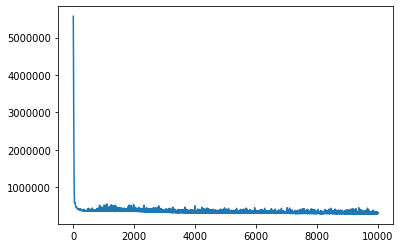

In [6]:
num_epochs=10000
verbose=True
sess = tf.Session()
optimizer = tf.train.AdamOptimizer(0.01)
t = []
train = optimizer.minimize(-pacelbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(-sess.run(pacelbo))
    sess.run(train)
    if verbose:
        if i % 1000 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)
            print("\n" + str(i) + " var\t" + str(sess.run(var)), end="", flush=True)
            print("\n" + str(i) + " var\t" + str(sess.run(var)), end="", flush=True)
            print("\n" + str(i) + " entropy\t" + str(sess.run(entropy)), end="", flush=True)
            print("\n" + str(i) + " entropy\t" + str(sess.run(entropy)), end="", flush=True)
            print("\n" + str(i) + " kl\t" + str(sess.run(energy - entropy)), end="", flush=True)
            print("\n" + str(i) + " kl\t" + str(sess.run(energy - entropy)), end="", flush=True)
            print("\n" + str(i) + " hmax\t" + str(sess.run(tf.reduce_mean(hmax))), end="", flush=True)

plt.plot(t)

## Evaluating the learned model
Once the model is learned, we evaluate how it makes predictions by ploting its associated epistemic and aleatoric uncertainty

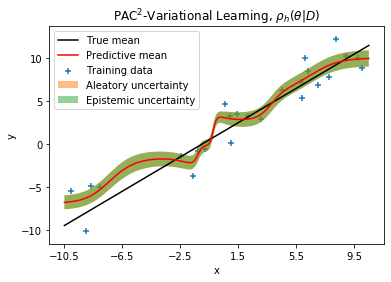

In [7]:
NSAMPLETEST = 10000
x_test = np.linspace(-10.5, 10.5, NSAMPLETEST).reshape(-1, 1)
r_test = 1+np.float32(np.random.normal(size=(NSAMPLETEST,1),scale=VAR))
y_test = np.float32(x_test*1.0+r_test*1.0)

with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_test)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLETEST)

y_pred_list = []
y_pred_noise = []

for i in range(100):
    [mean, noise] = sess.run([py.distribution.mean(), py])
    y_pred_list.append(mean)
    y_pred_noise.append(noise)

y_preds = np.concatenate(y_pred_list, axis=1)
y_preds_noise = np.concatenate(y_pred_noise, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

y_sigma_noise = np.std(y_preds_noise, axis=1)

plt.plot(x_test, np.float32(x_test*1.0+1.0), 'k-', label='True mean');
plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma_noise,
                 y_mean - 2 * y_sigma_noise,
                 alpha=0.5, label='Aleatory uncertainty')

plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')


plt.ylabel('y')
plt.xlabel('x')


plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();

if LEARNING_METHOD==3:
    plt.title(r'PAC$^2$-Variational Learning, $\rho_h(\theta|D)$')
elif LEARNING_METHOD==2:
    plt.title(r'PAC$^2$-Variational Learning, $\rho(\theta|D)$')
elif LEARNING_METHOD==1:
    plt.title(r'Variational Inference')
elif LEARNING_METHOD==0:
    plt.title(r'MAP Inference')

plt.show()

We now have a look at the $\hat{\mathbb{V}}_h$ value of the convergence point.

In [8]:
with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_train,y=y_train)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLE)

y_pred_list = []
for i in range(100):
    y_pred_list.append(sess.run(py.distribution.log_prob(py.value)))

total = np.concatenate(y_pred_list,axis=1)

logmax = tf.math.reduce_max(total,axis=1)
logmax_rep = tf.transpose(tf.reshape(tf.tile(logmax,[100]),[100,NSAMPLE]))
logmean = tf.math.reduce_logsumexp(total-logmax_rep, axis=1) - tf.log(100.)
logmeansquare = tf.math.reduce_logsumexp(2*total-2*logmax_rep, axis=1) - tf.log(100.)

alpha = logmean-logmax
hmaxtotal =  alpha/tf.math.pow(1-tf.math.exp(alpha),2.) + tf.math.pow(tf.math.exp(alpha)*(1-tf.math.exp(alpha)),-1.)

varTotal = tf.exp(logmeansquare) - tf.exp(logmean)*tf.exp(logmean)
hmaxvarTotal= tf.math.reduce_sum(tf.math.multiply(varTotal,hmaxtotal))


print("Var_h value of the convergence point is: "+str(sess.run(hmaxvarTotal)))

Var_h value of the convergence point is: 290.03983


Finally, we plot the histograms plotted at Figure 8. 

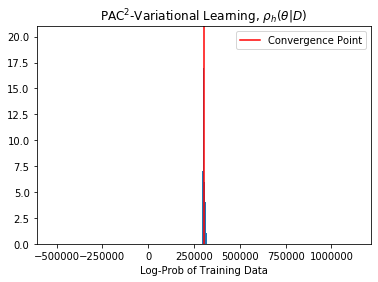

In [9]:
[W_loc,b_loc,W_out_loc,b_out_loc] = locs
[W_scale,b_scale,W_out_scale,b_out_scale] = scales

if not LEARNING_METHOD==0:
    eval = []
    for p in scales:
        eval.append(p.assign(-10000 + np.zeros(p.shape)))

    sess.run(eval)

center = sess.run(-dataenergy)

vals = []
for p in locs:
    vals.append(sess.run(p))

hist = []
y_pred_list= []
v = 0.01
for i in range(100):
    eval = []
    for i in range(len(locs)):
        eval.append(locs[i].assign(vals[i]+np.random.normal(scale=v, size = locs[i].shape)))
    sess.run(eval)
    hist.append(sess.run(-dataenergy))

plt.xlim(center-3*center, center+3*center)
plt.xlabel("Log-Prob of Training Data")
plt.axvline(x=center, color='r', label='Convergence Point')
plt.hist(hist,align='left')
plt.legend()


if LEARNING_METHOD==3:
    plt.title(r'PAC$^2$-Variational Learning, $\rho_h(\theta|D)$')
elif LEARNING_METHOD==2:
    plt.title(r'PAC$^2$-Variational Learning, $\rho(\theta|D)$')
elif LEARNING_METHOD==1:
    plt.title(r'Variational Inference')
else:
    plt.title(r'MAP Inference')

plt.show()

And compute the Pearson variation coefficient, 

In [10]:
cv = -np.std(hist)/np.mean(hist)*100
print("Pearson variation coefficient: " + str(cv))

Pearson variation coefficient: -1.5450081788003445
